# Create CSV files with FHR from the binary files provided in the FHRMA toolbox

## Use of the FHRMA toolbox and code

FHR Morphological Analysis Toolbox  Copyright (C) 2018 Samuel Boudet, Faculté de Médecine et Maïeutique,

samuel.boudet@gmail.com

FHR Morphological Analysis Toolbox  is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

FHR Morphological Analysis Toolbox  is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

GNU General Public License - <http://www.gnu.org/licenses/>.

## About the CTG files
The FHRMA toolbox provides 66 training files and 90 test files with raw CTG data. They are stored as binary .fhr files. The signals were sampled at 4 Hz and stored in the following format. For each sample:
* A uint32 serves as the UNIX timestamp for the beginning of the recording
* A uint16 corresponds to the FHR from the first sensor (multiplied by 4)
* A uint16 for the FHR signal from the second sensor (multiplied by 4) (unused here)
* A uint8 for the TOCO signal (multiplied by 2)
* A uint8 reserved to store signal quality (unused here).

The FHR signal is set to 0 when it is missing.

## Background information on binary files
Binary files consist of sequential bytes, which are each 8 bits long. Bits are 0s and 1s.

Binary files typically have a header indicating the file type.

A byte can represent a number from 0 to 255, or -127 to +127 if you use one bit to indicate the minus sign. Groups of bytes can be used to represent larger numbers, for example:
| Number of bytes (or bits) | Name | Range (will - this to + this) |
| --- | --- | --- |
| 1 (8 bits) | Byte | 128 |
| 2 (16 bits) | Short | 32,768 |
| 4 (32 bits) | Int | 2,147,483,648 |
| 8 (64 bits) | Int64 | 9,223,372,036,854,775,808 |

## Implementation in MATLAB

The .fhr files can be opened with the `fhropen.m` function in MATLAB - below is an excerpt that will open a file and save to csv (their version didn't include that, was just when I was testing in Octave) -

```
clear;

% Set filename
filename='test02';

% Open file
f=fopen([filename, '.fhr'], 'r');

% Load timestamp for beginning of recording
timestamp=fread(f,1,'uint32');

% Load FHR data - first corresponds to first sensor, and
% second corresponds to second sensor (which they don't use)
% This reads 3 x 10,000,000 array
data=fread(f,[3,10000000],'uint16');
FHR1=data(1,:)/4;
FHR2=data(2,:)/4;

fseek(f,4,'bof');

% TOCO signal
data=fread(f,[6,10000000],'uint8');
TOCO=data(5,:)/2;

MHR=zeros(size(FHR1));
infos=[];
fclose(f);

% Save FHR1 to a file for use in python
csvwrite([filename, '.csv'], transpose(FHR1));
```

I believe they then applied pre-processing using their function `preprocess.m`, which is copied below (d if first sample of non-missing signal, and f is last sample of non-missing signal) -

```
function [FHRi,FHR,TOCO,d,f]=preprocess(FHR1,FHR2,TOCO,unreliableSignal)

FHR=max([FHR1;FHR2]);
if nargin>=4
    for j=1:size(unreliableSignal,1)
        FHR(round(unreliableSignal(j,1)*240+1):round(unreliableSignal(j,2)*240))=0;
    end
end
FHR=removesmallpart(FHR);
d=find(FHR>0,1);


[FHRi,d,f]=interpolFHR(FHR);
%FHRi=FHRi(d:f);TOCOi=TOCO(d:f);FHR=FHR(d:f);
FHR(FHR==0)=NaN;
```

That function uses `removesmallpart()` which is copied below also.

```
function FHR=removesmallpart(FHR)
    FHR(FHR>220|FHR<50)=0;
    n=find(FHR(1:end-1)==0 & FHR(2:end)>0)+1;
    for i=1:length(n)
        f=find(FHR(n(i):end)==0,1,'first');
        if f<5*4
        	FHR(n(i):n(i)+f)=0;
        end
    end
    
    
    n=find(FHR(1:end-1)==0 & FHR(2:end)>0)+1;
    for i=1:length(n)
        f=find(FHR(n(i):end)==0,1,'first');
        if f<30*4
            
            lastvalid=find(FHR(1:n(i)-1)>0,1,'last');
            nextvalid=find(FHR(n(i)+f:end)>0,1,'first')+n(i)+f-1;
            
            try
                if(  (FHR(n(i))-FHR(lastvalid)<-25 && FHR(n(i)+f-2)-FHR(nextvalid)<-25 ))
                    FHR(n(i):n(i)+f)=0;
                end
                if(  (FHR(n(i))-FHR(lastvalid)>25 && FHR(n(i)+f-2)-FHR(nextvalid)>25 ))
                    FHR(n(i):n(i)+f)=0;
                end
            catch
            end
        end
    end

end
```

## Implementation in Python

### Set up

Load required packages.

In [1]:
from dataclasses import dataclass
import glob
from itertools import groupby
import matplotlib.pyplot as plt
import numpy as np
import os
from operator import itemgetter
import pandas as pd

Define file paths.

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    fhrma = './fhrma/train_test_data/'
    train_fhr = 'traindata_fhr/'
    test_fhr = 'testdata_fhr/'
    train_csv = 'traindata_csv/'
    test_csv = 'testdata_csv/'


paths = Paths()

### Define functions for import and pre-processing

Define function for extracting FHR and saving to csv.

In [3]:
def import_fhr(file_path):
    '''
    Imports .fhr files, extracts the data corresponding to FHR1 and FHR2

    Parameters:
    -----------
    file_path : string
        Location of the .fhr file

    Outputs:
    --------
    fhr1 : array
        FHR signal from the first sensor
    fhr2: array
        FHR signal from the second sensor
    name: string
        Name of the record for these FHR signals
    '''
    # Read file as uint16
    content = np.fromfile(file_path, dtype=np.uint16)

    # Ignore first two bytes, then reshape so you have a 3 x n array
    data = content[2:10000000-1].reshape(-1, 3).T

    # Take first array which corresponds to first sensor
    fhr1 = data[0]/4
    # Take second array which corresponds to second sensor
    fhr2 = data[1]/4

    # Get file name (remove path, change to csv)
    name = file_path.rsplit('/', 1)[1].replace('.fhr', '.csv')

    return(fhr1, fhr2, name)

Define functions used for pre-processing of the FHR signals.

In [4]:
def remove_small_part(fhr):
    '''
    Remove small sections of the signal that are non-physiological or extreme
    values (e.g. FHR too high, too low, or too great a change in a small period
    of time), and remove really short sections of signal surrounded by missing
    signal.

    Parameters
    ----------
    fhr : array
        Fetal heart rate

    Outputs:
    --------
    fhr : array
        Cleaned version of FHR
    '''
    # Remove extreme - set FHR to 0 if it is greater than 220bpm or less than 50bpm
    fhr[np.logical_or(fhr>220, fhr<50)] = 0

    # Find section of FHR that is preceded and followed by zero values - if that
    # section of non-zero values is too short (less than or equal to 5 seconds),
    # set all values in that section to zero

    # Get indices where FHR transitions from zero to non-zero value
    # (e.g. if n has index 396, then 395 was 0 and 396 was not zero)
    n = np.where((fhr[:-1] == 0) & (fhr[1:] > 0))[0] + 1

    # Loop through each of those transition points
    for i in range(len(n)):

        # Find the first occurence of 0 after non-zero section
        # e.g. if n=396 and f=28, FHR(396+27) takes you to the first zero
        # so the length of the non-zero section was f-1
        f = np.argmax(fhr[n[i]:] == 0)+1

        # If f is less than 5 seconds (5*4), set that whole section to zero
        if f < 5*4:
            fhr[n[i]:n[i]+f] = 0

    # Again, find section of FHR preceded and followed by zero values - if that
    # section is less than or equal to 30 seconds, compare the start and end point
    # of the section to the last non-zero point before and after. If the difference
    # in either of those comparisons is more than 25bpm, set the whole non-zero
    # section to zero
    # Diagram to help support understanding of the identified points below:
    # Explained with example, where 0 is zero and 1 is non-zero:
    # 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1
    # Location of n:
    # - - - - - - - - - - ! - - - - - - - - - - - - - - - - - - - - -
    # Contributors to length of f:
    # - - - - - - - - - - ! ! ! ! ! ! ! ! ! ! ! - - - - - - - - - - -
    # Location of lastvalid:
    # - - - - ! - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Location of firstvalid:
    # - - - - - - - - - - - - - - - - - - - - - - - - - - ! - - - - -

    # As above, find transition points and loop through them, first identifying
    # the first occurence of 0 after the non-zero section
    n = np.where((fhr[:-1] == 0) & (fhr[1:] > 0))[0] + 1
    for i in range(len(n)):
        f = np.argmax(fhr[n[i]:] == 0)+1

        # If f is less than 30 seconds (30*4)
        if f < 30*4:

            # Find index of last non-zero before start of zero section before n
            lastvalid = np.argmin(fhr[:396] > 0)
            # Find index of first non-zero after the zero section after f
            nextvalid = np.argmax(fhr[396+28:] > 0) + 396 + 28

            # Find difference in FHR between lastvalid and n(i)
            lastvalid_diff = fhr[n[i]] - fhr[lastvalid]
            # Find difference in FHR between last non-zero in f section, and nextvalid
            nextvalid_diff = fhr[n[i]+f-2] - fhr[nextvalid]

            # If both of those differences are more than an absolute value of 25bpm,
            # then set that f section of non-zero all to 0
            if (abs(lastvalid_diff) > 25) and (abs(nextvalid_diff) > 25):
                fhr[n[i]:n[i]+f] = 0

    return (fhr)

In [5]:
def interpol_fhr(fhr):
    '''
    Interpolation of missing signal, to match interpolfhr() in FHRMA

    Parameters
    ----------
    fhr : array
        Fetal heart rate

    Outputs:
    --------
    fhr : array
        Cleaned version of FHR
    '''
    # Get the first index where FHR is non-zero and non-NaN
    n = np.argmax(np.logical_and(fhr>0, np.isfinite(fhr)))

    # Set any values preceding that index to the value of that index
    fhr[:n] = fhr[n]

    # While you have a value of n, and whilst it's not reached the end of the FHR
    while n is not None and n!=-1:

        # Get index of first occurence after n that is zero or NaN
        n = np.argmax(np.logical_or(fhr==0, ~np.isfinite(fhr)))

        # Make boolean array of non-zero or non-NaN after n
        nf_mask = np.logical_and(fhr[n:]>0, np.isfinite(fhr[n:]))

        # If you have found a subsequent value that is non-zero or non-NaN...
        if nf_mask.any() and n!=0:

            # Get the index of the first value that is non-zero and non-NaN
            nf = np.argmax(nf_mask)+n

            # Linear interpolation between nf and the non-zero point before n
            fill = np.linspace(fhr[n-1], fhr[nf], nf-n)
            fill = np.append(fill, fill[-1:])
            fhr[(n-1):nf] = fill
            #fhr[n:nf] = fill

            # Set n to nf
            n = nf

        # If there were no subsequent values, exit the while loop
        else:
            n=-1

    # Get last index where FHR is non-zero and non-NaN
    n = pd.Series(np.logical_and(fhr>0, np.isfinite(fhr)))[::-1].idxmax()

    # Set any values following that index to the value of that index
    fhr[n:] = fhr[n]

    return (fhr)

In [6]:
fhr1, fhr2, name = import_fhr('./fhrma/train_test_data/traindata_fhr/train13.fhr')
fhr = np.maximum(fhr1, fhr2)
fhr = remove_small_part(fhr)

# Get the first index where FHR is non-zero and non-NaN
n = np.argmax(np.logical_and(fhr>0, np.isfinite(fhr)))

# Set any values preceding that index to the value of that index
fhr[:n] = fhr[n]

# While you have a value of n, and whilst it's not reached the end of the FHR
while n is not None and n!=-1:

    # Get index of first occurence after n that is zero or NaN
    n = np.argmax(np.logical_or(fhr==0, ~np.isfinite(fhr)))

    # Make boolean array of non-zero or non-NaN after n
    nf_mask = np.logical_and(fhr[n:]>0, np.isfinite(fhr[n:]))

    # If you have found a subsequent value that is non-zero or non-NaN...
    if nf_mask.any() and n!=0:

        # Get the index of the first value that is non-zero and non-NaN
        nf = np.argmax(nf_mask)+n

        print(f'n:{n} and nf:{nf}')

        # Linear interpolation between nf and the non-zero point before n
        # Duplicate the final value
        fill = np.linspace(fhr[n-1], fhr[nf], nf-n)
        fill = np.append(fill, fill[-1:])

        # Save for tracking
        pre = pd.Series(fhr[n-5:nf+5].copy(), name='pre')

        # Fill from non-zero point before n (setting to same value as it was)
        # to the point before nf
        fhr[(n-1):nf] = fill

        # Show change
        post = pd.Series(fhr[n-5:nf+5], name='post')
        display(pre.to_frame().join(post))

        # Set n to nf
        n = nf

    # If there were no subsequent values, exit the while loop
    else:
        n=-1

# Get last index where FHR is non-zero and non-NaN
n = pd.Series(np.logical_and(fhr>0, np.isfinite(fhr)))[::-1].idxmax()

# Set any values following that index to the value of that index
fhr[n:] = fhr[n]

n:11733 and nf:11763


,pre,post
0,109.0,109.000000
1,109.0,109.000000
2,109.0,109.000000
3,109.0,109.000000
4,109.0,109.000000
5,0.0,110.568966
6,0.0,112.137931
7,0.0,113.706897
8,0.0,115.275862
9,0.0,116.844828


n:23391 and nf:23402


,pre,post
0,124.75,124.75
1,124.75,124.75
2,124.75,124.75
3,124.75,124.75
4,124.75,124.75
5,0.00,121.40
6,0.00,118.05
7,0.00,114.70
8,0.00,111.35
9,0.00,108.00


The gap is eleven zeros. In FHRMA, they set the start and end matching the values before and after, and then have 9 different numbers in between.

In [7]:
def preprocess(fhr1, fhr2):
    '''
    Pre-process the FHR1 and FHR2 signals - merging the signals from each
    sensor, removing empty signal at the beginning and end, removing small parts
    of the signal that are not trustable, and linear interpolation of missing
    parts of the signal.

    Parameters:
    -----------
    fhr1 : array
        FHR signal from the first sensor
    fhr2: array
        FHR signal from the second sensor

    Outputs:
    --------
    new_sig : array
        Cleaned FHR signal
    '''
    # Find the max value element-wise of the two arrays
    # This should hopefully fill the occurences where FHR=0 (i.e. no signal)
    fhr = np.maximum(fhr1, fhr2)

    # Clean using removesmallpart() - this will remove small sections of the
    # signal that are non-physiological or extreme values (e.g. FHR too high,
    # too low, or too great a change in a small period of time), and remove
    # really short sections of signal surrounded by missing signal.
    fhr = remove_small_part(fhr)

    # Perform linear interpolation
    fhr = interpol_fhr(fhr)

    # If any zero remain, set to NaN
    fhr[fhr==0] = np.nan

    # Return the cleaned signal
    return (fhr)

Define function for import, pre-processing and saving to csv for all files in a given directory

In [8]:
def convert_fhr_to_csv(fhr_path, csv_path):
    '''
    Imports all .fhr files in a given directory, extracts the data corresponding
    to FHR1 and FHR2, pre-process and save to csv.

    Parameters:
    -----------
    fhr_path : string
        Location of .fhr files
    csv_path : string
        Location to save the .csv files
    '''
    # Get list of all the .fhr file names in the directory
    files = glob.glob(os.path.join(fhr_path, '*.fhr'))

    # Loop through those files...
    for file_path in files:

        print(f'Started: {file_path}')

        # Import the signals and record name
        fhr1, fhr2, name = import_fhr(file_path)

        # Pre-process the signals
        fhr = preprocess(fhr1, fhr2)

        # Save to csv
        np.savetxt(os.path.join(csv_path, name), fhr, delimiter=',')

### Run functions on an example, to help demonstrate impact of the cleaning process

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[146.25 147.   147.   146.5  146.5  146.   146.25 146.25 145.   145.  ]
train40.csv


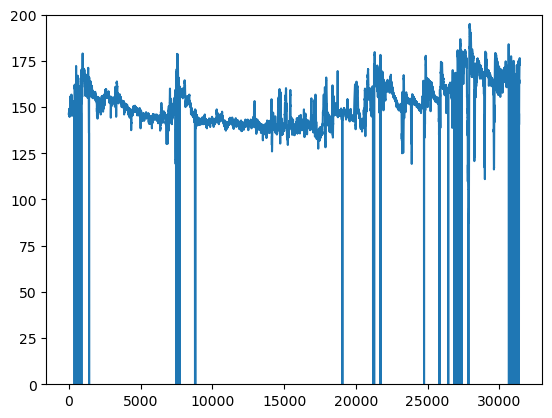

In [9]:
# Import an example file
file_path = os.path.join(paths.fhrma, paths.train_fhr, 'train40.fhr')
fhr1, fhr2, name = import_fhr(file_path)

# Preview data
print(fhr1[:10])
print(fhr2[:10])
print(name)

# Plot one of the data
plt.plot(fhr2)
plt.ylim([0, 200])
plt.show()

[146.25 147.   147.   146.5  146.5  146.   146.25 146.25 145.   145.  ]


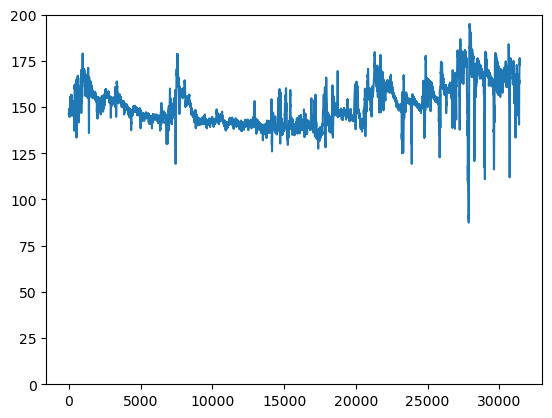

In [10]:
# Pre-process
fhr = preprocess(fhr1, fhr2)

# Preview
print(fhr[:10])

# Plot
plt.plot(fhr)
plt.ylim([0, 200])
plt.show()

### Apply functions to the training and test datasets

In [11]:
convert_fhr_to_csv(
    fhr_path = os.path.join(paths.fhrma, paths.train_fhr),
    csv_path = os.path.join(paths.fhrma, paths.train_csv)
)

Started: ./fhrma/train_test_data/traindata_fhr/train64.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train55.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train13.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train17.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train49.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train40.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train46.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train43.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train29.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train08.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train07.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train28.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train18.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train47.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train61.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train21.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train57.f

In [12]:
convert_fhr_to_csv(
    fhr_path = os.path.join(paths.fhrma, paths.test_fhr),
    csv_path = os.path.join(paths.fhrma, paths.test_csv)
)

Started: ./fhrma/train_test_data/testdata_fhr/test75.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test40.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test23.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test06.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test54.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test51.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test65.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test45.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test87.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test74.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test88.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test41.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test55.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test05.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test15.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test50.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test11.fhr
Started: ./fhrma/train_test_dat

## Compare MATLAB and Python implementation

To validate implementation in Python, compare against the signals obtained from Octave (MATLAB).

In [13]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict
    Inputs:
    directory - string, location of csv files
    output_dict - dictionary, to save files to
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

In [14]:
# Import and csv files produced in python
fhr_python = import_csv(
    directory='./fhrma/train_test_data/traindata_csv/',
    output_dict=dict())
fhr_python = import_csv(
    directory='./fhrma/train_test_data/testdata_csv/',
    output_dict=fhr_python)
fhr_python_df = pd.DataFrame([[key,value] for key,value in fhr_python.items()],
                             columns=['record', 'python'])

# Import and csv files produced in Octave
fhr_fhrma = import_csv(
    directory='./fhrma/train_test_data/traindata_octave_csv/',
    output_dict=dict())
fhr_fhrma = import_csv(
    directory='./fhrma/train_test_data/testdata_octave_csv/',
    output_dict=fhr_fhrma)
fhr_fhrma_df = pd.DataFrame([[key,value] for key,value in fhr_fhrma.items()],
                            columns=['record', 'fhrma'])

In [15]:
# Merge into a single dataframe
compare_fhr = pd.merge(fhr_python_df, fhr_fhrma_df)

#compare_fhr['n_match'] = np.nan
#compare_fhr['total_possible'] = np.nan
#compare_fhr['all_match'] = np.nan

# Loop through each record, comparing the python and FHRMA results
for index, row in compare_fhr.iterrows():

    # Extract the two arrays
    res_python = row['python']
    res_fhrma = row['fhrma']

    # Save number of matches, total possible matches, and every element matches
    compare_fhr.loc[compare_fhr.index[index], 'n_match'] = (res_python==res_fhrma).sum()
    compare_fhr.loc[compare_fhr.index[index], 'total_possible'] = len(res_python)
    compare_fhr.loc[compare_fhr.index[index], 'all_match'] = (res_python==res_fhrma).all()

# Add column showing number of non-matching elements
compare_fhr['n_different'] = compare_fhr['total_possible'] - compare_fhr['n_match']

# Preview dataframe
compare_fhr.head()

,record,python,fhrma,n_match,total_possible,all_match,n_different
0,train28,"[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...","[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...",17595.0,17595.0,True,0.0
1,train04,"[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...","[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...",17595.0,17595.0,True,0.0
2,train31,"[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...","[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...",11631.0,11631.0,True,0.0
3,train13,"[210.0, 210.0, 210.0, 210.0, 210.0, 210.0, 210...","[210.0, 210.0, 210.0, 210.0, 210.0, 210.0, 210...",29196.0,29226.0,False,30.0
4,train47,"[153.5, 153.0, 153.5, 153.5, 153.5, 153.5, 152...","[153.5, 153.0, 153.5, 153.5, 153.5, 153.5, 152...",25401.0,28022.0,False,2621.0


Total matches -

In [16]:
compare_fhr['all_match'].value_counts()

all_match
False    126
True      30
Name: count, dtype: int64

Looking at an example of a record with differences -

In [17]:
res_python = compare_fhr.loc[compare_fhr['record'] == 'train13', 'python'].to_numpy()[0]
res_fhrma = compare_fhr.loc[compare_fhr['record'] == 'train13', 'fhrma'].to_numpy()[0]

# Make boolean array showing where arrays match elementwise
mask = (res_python == res_fhrma)

# Get indices of mismatch
mismatch = [i for i, x in enumerate(~mask) if x]

In [18]:
def group(L):
    '''
    Function to identify consecutive numbers
    https://stackoverflow.com/questions/2154249/identify-groups-of-consecutive-numbers-in-a-list
    '''
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

# Print start and end of conseuctive numbers in mismatch
list(group(mismatch))

[(11733, 11762)]

As you can see below, the difference appears to be the end point of interpolation...

In [19]:
# View example of record with differences to see where they start to differ
example = pd.Series(res_fhrma[11733-5:11763+5], name='fhrma').to_frame().join(
    pd.Series(res_python[11733-5:11763+5], name='python'))
example['compare'] = np.where(
    example['fhrma']==example['python'], 'same', 'different')
example

,fhrma,python,compare
0,109.000000,109.000000,same
1,109.000000,109.000000,same
2,109.000000,109.000000,same
3,109.000000,109.000000,same
4,109.000000,109.000000,same
5,110.467742,110.568966,different
6,111.935484,112.137931,different
7,113.403226,113.706897,different
8,114.870968,115.275862,different
9,116.338710,116.844828,different


In [20]:
# Matches FHRMA
m = np.linspace(109, 154.5, 32)
print(len(m))
print(m)

32
[109.         110.46774194 111.93548387 113.40322581 114.87096774
 116.33870968 117.80645161 119.27419355 120.74193548 122.20967742
 123.67741935 125.14516129 126.61290323 128.08064516 129.5483871
 131.01612903 132.48387097 133.9516129  135.41935484 136.88709677
 138.35483871 139.82258065 141.29032258 142.75806452 144.22580645
 145.69354839 147.16129032 148.62903226 150.09677419 151.56451613
 153.03225806 154.5       ]


In [21]:
# View example of record with differences to see where they start to differ
example = pd.Series(res_fhrma[23391-5:23402+5], name='fhrma').to_frame().join(
    pd.Series(res_python[23391-5:23402+5], name='python'))
example['compare'] = np.where(
    example['fhrma']==example['python'], 'same', 'different')
example

,fhrma,python,compare
0,124.75,124.75,same
1,124.75,124.75,same
2,124.75,124.75,same
3,124.75,124.75,same
4,124.75,124.75,same
5,121.40,121.40,same
6,118.05,118.05,same
7,114.70,114.70,same
8,111.35,111.35,same
9,108.00,108.00,same


In [22]:
# Matches FHRMA
np.linspace(124.75, 91.25, 11)

array([124.75, 121.4 , 118.05, 114.7 , 111.35, 108.  , 104.65, 101.3 ,
        97.95,  94.6 ,  91.25])

In [23]:
# Matches my current python
np.linspace(124.75, 91.25, 13)

array([124.75      , 121.95833333, 119.16666667, 116.375     ,
       113.58333333, 110.79166667, 108.        , 105.20833333,
       102.41666667,  99.625     ,  96.83333333,  94.04166667,
        91.25      ])

In [24]:
len(res_fhrma)

29226

In [25]:
res_fhrma[23401:23401+50]

array([91.25, 91.25, 91.25, 91.25, 91.25, 92.75, 92.75, 92.75, 92.75,
       92.75, 92.75, 91.  , 91.  , 91.  , 90.75, 90.75, 90.75, 91.25,
       91.25, 91.25, 86.5 , 86.5 , 86.5 , 91.75, 91.75, 91.75, 92.5 ,
       92.5 , 92.5 , 93.  , 93.  , 93.  , 95.5 , 95.5 , 95.5 , 95.5 ,
       95.5 , 95.5 , 95.5 , 95.5 , 95.5 , 92.5 , 92.5 , 92.5 , 87.25,
       87.25, 87.25, 87.25, 87.25, 87.25])